In [1]:
SEED = 61

import numpy as np
import tensorflow as tf
import random as python_random
import os

def reset_seeds():
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    
import os
import re
import gc
import tensorflow_addons as tfa
import h5py
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk import tokenize

from sklearn import preprocessing
from sklearn.decomposition import PCA

from keras import backend as K
from keras import initializers,regularizers,constraints
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, Input, Embedding, Flatten, Dense, Dropout, BatchNormalization, Activation #, merge
from keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import RepeatVector, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import cross_val_score

from tensorflow.python.keras.layers import Layer, InputSpec, Lambda

from transformers import BertTokenizer, BertForMaskedLM, BertModel

# from tensorflow.keras import Model
# from attention import Attention_input1, Attention_input2
# from keras.optimizers import SGD, RMSprop, Adagrad

In [2]:
def read_hdf5(path):
    read_file = h5py.File(path, 'r')
    
    feature_names = list(read_file.keys())
    loaded_data = []
    
    for name in feature_names:
        dataset = read_file[name][:]
        if dataset.dtype == np.dtype('object'):
            dataset = np.array([x.decode('UTF-8') for x in dataset])            
        loaded_data.append((name, dataset))

    return loaded_data

def loadz(path):
    data = np.load(path)['arr_0']
    return data

In [3]:
def load_labels(path):
    data = read_hdf5(path)

    for x in data:
        if x[0] == 'multimodal-labels':
            labels = x[1]
        if x[0] == 'text-labels':
            text_labels = x[1]
        if x[0] == 'image-labels':
            image_labels = x[1]
        
    return labels, text_labels, image_labels

In [4]:
def plot_metrics(history):
    fig = plt.figure(figsize=(20, 5))

    fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LOSS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 3, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    fig.add_subplot(1, 3, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F1-SCORE')
    plt.ylabel('f1-score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

    plt.show()

In [5]:
# e.g. validation_split=0.1 -----> 8:1:1 ratio of train, val, test
def split_data(data, validation_split):
    num_val = int(validation_split * data.shape[0])
    data_train = data[:-(num_val*2)]
    data_val = data[-(num_val*2):-(num_val)]
    data_test = data[-num_val:]
    return data_train, data_val, data_test

In [6]:
def create_model_pretrained():
    f1_score = tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='micro')
    
    image_input = Input(shape=image_train.shape[1:])
#     x = Reshape((1, -1)) (image_input)
#     x = LSTM(128) (x)
    outputs = Dense(NUM_CLASSES, activation='softmax') (image_input)
    
    model = Model(image_input, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score]) # f1 #tf.keras.metrics.AUC()
    print(model.summary())
    return model

# Load data

In [7]:
def merge_mvsa(mvsa_single, mvsa_multiple):
    mvsa = np.concatenate((mvsa_single, mvsa_multiple), axis=0)
    return mvsa

def load_mvsa_feature(feature_name, merge=False):
    folder_path = os.path.join('../input/mvsa-features/', feature_name)
    single_file = 'mvsa-single-{}.npz'.format(feature_name)
    multiple_file = 'mvsa-multiple-{}.npz'.format(feature_name)
    mvsa_single = loadz(os.path.join(folder_path, single_file))
    mvsa_multiple = loadz(os.path.join(folder_path, multiple_file))
    
    if merge == True:
        return merge_mvsa(mvsa_single, mvsa_multiple)
    
    return mvsa_single, mvsa_multiple

In [8]:
# load separate
mvsa_single_vgg16, mvsa_multiple_vgg16 = load_mvsa_feature('vgg16')
mvsa_single_vgg19, mvsa_multiple_vgg19 = load_mvsa_feature('vgg19')
mvsa_single_resnet50, mvsa_multiple_resnet50 = load_mvsa_feature('resnet50')
mvsa_single_resnet101, mvsa_multiple_resnet101 = load_mvsa_feature('resnet101')
mvsa_single_resnet152, mvsa_multiple_resnet152 = load_mvsa_feature('resnet152')
mvsa_single_densenet121, mvsa_multiple_densenet121 = load_mvsa_feature('densenet121')
mvsa_single_densenet169, mvsa_multiple_densenet169 = load_mvsa_feature('densenet169')
mvsa_single_densenet201, mvsa_multiple_densenet201 = load_mvsa_feature('densenet201')

In [9]:
# load merge
mvsa_vgg16 = load_mvsa_feature('vgg16', merge=True)
mvsa_vgg19 = load_mvsa_feature('vgg19', merge=True)
mvsa_resnet50 = load_mvsa_feature('resnet50', merge=True)
mvsa_resnet101 = load_mvsa_feature('resnet101', merge=True)
mvsa_resnet152 = load_mvsa_feature('resnet152', merge=True)
mvsa_densenet121 = load_mvsa_feature('densenet121', merge=True)
mvsa_densenet169 = load_mvsa_feature('densenet169', merge=True)
mvsa_densenet201 = load_mvsa_feature('densenet201', merge=True)

In [10]:
mvsa_single_multimodal_labels, mvsa_single_text_labels, mvsa_single_image_labels = load_labels('../input/mvsa-features/labels/mvsa-single-labels.hdf5')
mvsa_multiple_multimodal_labels, mvsa_multiple_text_labels, mvsa_multiple_image_labels = load_labels('../input/mvsa-features/labels/mvsa-multiple-labels.hdf5')

mvsa_multimodal_labels = merge_mvsa(mvsa_single_multimodal_labels, mvsa_multiple_multimodal_labels)
mvsa_text_labels = merge_mvsa(mvsa_single_text_labels, mvsa_multiple_text_labels)
mvsa_image_labels = merge_mvsa(mvsa_single_image_labels, mvsa_multiple_image_labels)

In [11]:
le = preprocessing.LabelEncoder()
le.fit(mvsa_multimodal_labels)
NUM_CLASSES = len(le.classes_) # =3

In [42]:
tokenized_labels = le.fit_transform(mvsa_multimodal_labels)
labels = to_categorical(np.asarray(tokenized_labels))

In [59]:
VALIDATION_SPLIT = 0.1

# text_train, text_val, text_test = split_data(mvsa_single_bert, VALIDATION_SPLIT)
image_train, image_val, image_test = split_data(mvsa_vgg16, VALIDATION_SPLIT)
label_train, label_val, label_test = split_data(labels, VALIDATION_SPLIT)

print('Number of train data:', label_train.shape[0])
print('Number of validation data:', label_val.shape[0])
print('Number of test data:', label_test.shape[0])

print('Image VGG-16 vector dimension:', image_train.shape[1:])

Number of train data: 16563
Number of validation data: 2070
Number of test data: 2070
Image VGG-16 vector dimension: (4096,)


In [150]:
reset_seeds()
EPOCHS = 100
BATCH_SIZE = 1000

In [151]:
model_pretrained = create_model_pretrained()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 4096)]            0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 1, 4096)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               2163200   
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 2,163,587
Trainable params: 2,163,587
Non-trainable params: 0
_________________________________________________________________
None


In [152]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
checkpoint_pretrained = ModelCheckpoint('./model_checkpoint/{}.h5'.format('pretrained'), save_best_only=True, verbose=1)

In [153]:
history_pretrained = model_pretrained.fit(image_train, label_train, validation_data=(image_val, label_val), 
                     epochs=EPOCHS, batch_size=BATCH_SIZE, 
                     callbacks=[checkpoint_pretrained])

Epoch 1/100
17/17 [==============================] - 5s 134ms/step - loss: 0.9783 - accuracy: 0.6385 - f1_score: 0.6385 - val_loss: 0.7646 - val_accuracy: 0.7208 - val_f1_score: 0.7208

Epoch 00001: val_loss improved from inf to 0.76456, saving model to ./model_checkpoint/pretrained.h5
Epoch 2/100
17/17 [==============================] - 2s 94ms/step - loss: 0.8835 - accuracy: 0.6463 - f1_score: 0.6463 - val_loss: 0.7629 - val_accuracy: 0.7208 - val_f1_score: 0.7208

Epoch 00002: val_loss improved from 0.76456 to 0.76290, saving model to ./model_checkpoint/pretrained.h5
Epoch 3/100
17/17 [==============================] - 2s 91ms/step - loss: 0.8805 - accuracy: 0.6463 - f1_score: 0.6463 - val_loss: 0.7587 - val_accuracy: 0.7208 - val_f1_score: 0.7208

Epoch 00003: val_loss improved from 0.76290 to 0.75868, saving model to ./model_checkpoint/pretrained.h5
Epoch 4/100
17/17 [==============================] - 2s 94ms/step - loss: 0.8773 - accuracy: 0.6463 - f1_score: 0.6463 - val_loss: 0.

# Evaluation

In [98]:
model_pretrained = load_model('./model_checkpoint/{}.h5'.format('pretrained'))#, custom_objects={'f1': f1})
loss_pretrained, acc_pretrained, f1_pretrained = model_pretrained.evaluate(image_test, label_test)
print('\Model with pretrained CNN features evaluation')
print('Loss:', loss_pretrained)
print('Accuracy:', acc_pretrained)
print('F1-score:', f1_pretrained)

65/65 [==============================] - 0s 2ms/step - loss: 0.8292 - accuracy: 0.6628 - f1_score: 0.6628
\Model with pretrained CNN features evaluation
Loss: 0.8292338848114014
Accuracy: 0.6628019213676453
F1-score: 0.6628019213676453


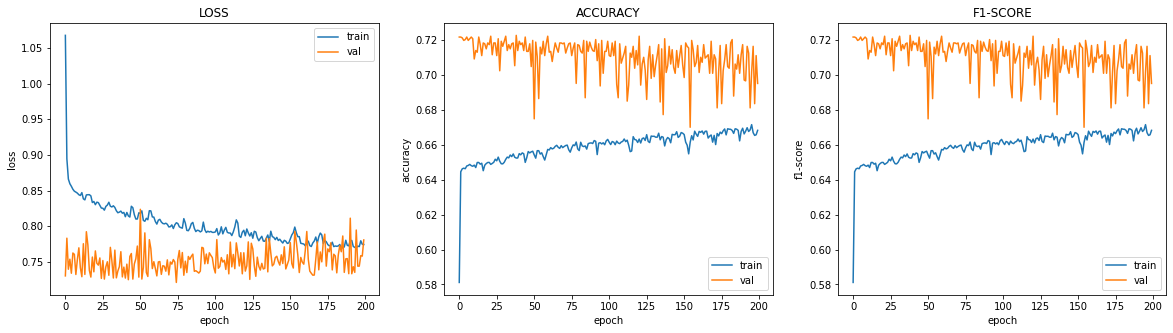

In [99]:
plot_metrics(history_pretrained)

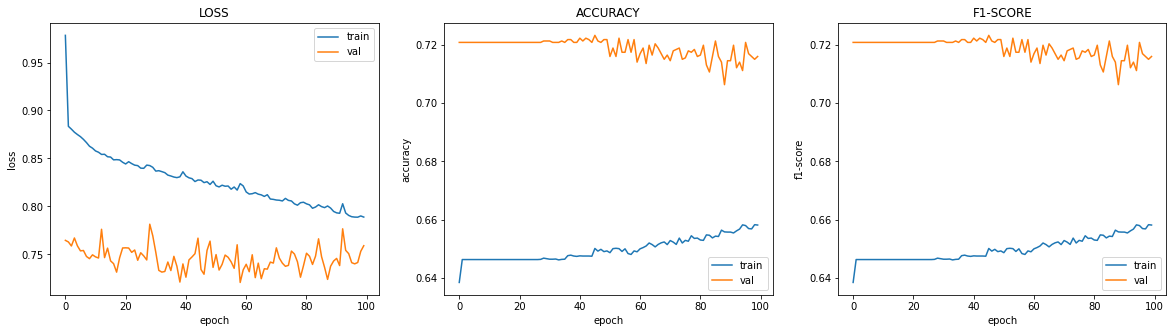

In [154]:
plot_metrics(history_pretrained)

In [ ]:
# def f1(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val